In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os, sys

In [3]:
import pylab as plt
import matplotlib

import numpy as np
import pandas as pd

In [4]:
sys.path.append('..')

from pyMultiOmics.base import *
from pyMultiOmics.mapping import Mapper
from pyMultiOmics.common import set_log_level_info, set_log_level_debug
from pyMultiOmics.constants import *
from pyMultiOmics.mofax import *

2021-08-24 23:59:34.254 | WARNING  | pyMultiOmics.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2021-08-24 23:59:34.328 | INFO     | pyMultiOmics.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


In [5]:
DATA_FOLDER = os.path.abspath(os.path.join('test_data', 'aging_data'))
DATA_FOLDER

'/Users/wangkeqing/pyMultiOmics/notebooks/test_data/aging_data'

In [6]:
def get_measurements(data_folder, filename):
    df = pd.read_csv(os.path.join(data_folder, filename), sep='\t', index_col='SampleID')
    try:
        df = df.drop(columns=['SubjectID', 'CL1', 'CL2', 'CL3', 'CL4'])
    except KeyError:
        pass
    df = df.transpose()
    df.index.name = IDENTIFIER_COL
    df.columns.name = SAMPLE_COL
    return df

In [7]:
transcript_df = get_measurements(DATA_FOLDER, 'transcriptomic.txt')
protein_df = get_measurements(DATA_FOLDER, 'proteomics.txt')
compound_df = get_measurements(DATA_FOLDER, 'metabolomics.txt')
targeted_assays_df = get_measurements(DATA_FOLDER, 'targeted_assays.txt')
clinical_df = pd.read_csv(os.path.join(DATA_FOLDER, 'clinic.txt'), sep='\t', index_col='sample')

In [8]:
transcript_data = SingleOmicsData(GENES, transcript_df, clinical_df)
protein_data = SingleOmicsData(PROTEINS, protein_df, clinical_df)
compound_data = SingleOmicsData(COMPOUNDS, compound_df, clinical_df)
targeted_assay_data = SingleOmicsData('targeted_assay', targeted_assays_df, clinical_df)


2021-08-24 23:59:48.085 | WARNING  | pyMultiOmics.base:_drop_dupes_by_values:89 - Dropped duplicate from measurement dataframe by values: 0 rows and 13 cols
2021-08-24 23:59:48.109 | WARNING  | pyMultiOmics.base:_drop_dupes_by_colnames:105 - Dropped 5 duplicate sample names from measurement dataframe
2021-08-24 23:59:48.147 | WARNING  | pyMultiOmics.base:_drop_dupes_by_colnames:105 - Dropped 4 duplicate sample names from sample metadata dataframe
2021-08-24 23:59:48.191 | WARNING  | pyMultiOmics.base:_keep_common_samples:122 - Dropped 68 columns from measurement dataframe due to missing metadata
2021-08-24 23:59:48.192 | WARNING  | pyMultiOmics.base:_keep_common_samples:126 - Dropped 170 columns from sample metadata due to missing measurements
2021-08-24 23:59:48.492 | WARNING  | pyMultiOmics.base:_drop_dupes_by_colnames:105 - Dropped 5 duplicate sample names from measurement dataframe
2021-08-24 23:59:48.585 | WARNING  | pyMultiOmics.base:_drop_dupes_by_colnames:105 - Dropped 4 duplic

In [9]:
publication = 'Ahadi, Sara, et al. "Personal aging markers and ageotypes revealed by deep longitudinal profiling." Nature medicine 26.1 (2020): 83-90.'
url = 'https://www.nature.com/articles/s41591-019-0719-5'

In [10]:
mo = MultiOmicsData(publication=publication, url=url)
mo.add_data([transcript_data, protein_data, compound_data, targeted_assay_data])

In [11]:
df = mo.views['genes'].data_df


In [12]:
mo.to_mofa()

,feature,sample,value,view
0,A1BG,ZOZOW1T-1013,3.815272,genes
1,A1BG-AS1,ZOZOW1T-1013,2.346694,genes
2,A1CF,ZOZOW1T-1013,0.000000,genes
3,A2M,ZOZOW1T-1013,9.865330,genes
4,A2M-AS1,ZOZOW1T-1013,0.000000,genes
...,...,...,...,...
60781,ENA78,ZJTKAE3-6031,181.152491,targeted_assay
60782,CHEX1,ZJTKAE3-6031,10719.269590,targeted_assay
60783,CHEX2,ZJTKAE3-6031,805.705435,targeted_assay
60784,CHEX3,ZJTKAE3-6031,1358.829364,targeted_assay


In [13]:
filePath = DATA_FOLDER + '/aging_data.hdf5'
filePath

'/Users/wangkeqing/pyMultiOmics/notebooks/test_data/aging_data/aging_data.hdf5'

In [14]:
m = MofaPipeline(mo,filePath)
m.training()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        

No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='compounds' with N=889 samples and D=724 features...
Loaded group='single_group' view='genes' with N=795 samples and D=10346 features...
Loaded group='single_group' view='proteins' with N=901 samples and D=302 features...
Loaded group='single_group' vie

In [15]:
m.save_model()

Saving model in /Users/wangkeqing/pyMultiOmics/notebooks/test_data/aging_data/aging_data.hdf5...


In [16]:
m.build_mofa()

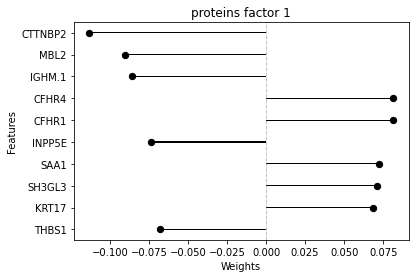

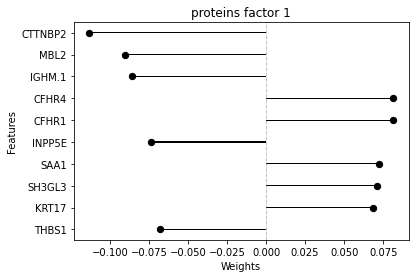

In [17]:
m.plot_top_features(factors = 1, views = 'proteins', n_features = 10)

<AxesSubplot:>

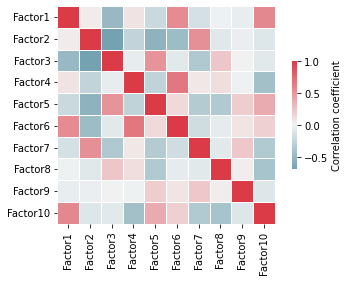

In [18]:
mfx.plot_factors_correlation(m.mofa)

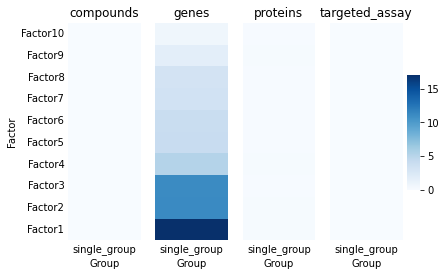

In [19]:
mfx.plot_r2(m.mofa)

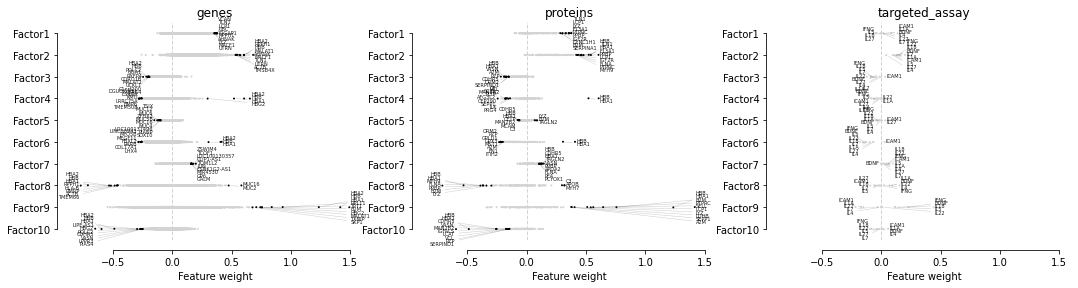

In [22]:
ax = mfx.plot_weights(m.mofa, factor=1, views = 'genes', n_features=10,
                      y_repel_coef=0.04, x_rank_offset=-150)

In [23]:
df = m.mofa.get_top_features(views = 'genes', factors = 1, n_features = 10,df = True)
df

,index,feature,factor,value,value_abs,view
0,3667,HBA2,Factor2,0.681862,0.681862,genes
1,7781,RPPH1,Factor2,0.605536,0.605536,genes
2,3668,HBB,Factor2,0.604955,0.604955,genes
3,3669,HBB,Factor2,0.604955,0.604955,proteins
4,5283,MALAT1,Factor2,0.573888,0.573888,genes
5,251,AHNAK,Factor2,0.569496,0.569496,genes
6,5260,MACF1,Factor2,0.551362,0.551362,genes
7,9155,TLN1,Factor2,0.541025,0.541025,genes
8,9156,TLN1,Factor2,0.541025,0.541025,proteins
9,9840,UTRN,Factor2,0.540954,0.540954,genes


In [ ]:
from mofapy2.run.entry_point import entry_point
import pandas as pd
import io
import requests # to download the online data
import numpy as np
import matplotlib.pyplot as plt
import h5py

import seaborn as sns
from matplotlib import rcParams
rcParams['figure.dpi'] = 200

import mofax as mfx
from typing import Union

In [3]:
def data_processing(dict_of_files):
    data = pd.DataFrame()
    for k in dict_of_files.keys():
        df = pd.read_csv(dict_of_files[k], sep="\t")
        df = df.rename(columns={df.columns[0]:'sample'})
        for col in df.columns:
            if col != 'sample':
                if isinstance(df[col][1], np.float64) == False:
                    df = df.drop(labels=col,axis=1)
        df = df.melt(id_vars=df.columns[0],var_name = 'feature')
        df['view'] = k
        data = data.append(df)
    return(data)

In [4]:
transcriptome_f = "/Users/wangkeqing/Desktop/master-gla/project/data/transcriptomic.txt"
proteome_f = "/Users/wangkeqing/Desktop/master-gla/project/data/proteomics.txt"
metabolome_f = "/Users/wangkeqing/Desktop/master-gla/project/data/metabolomics.txt"
targeted_f = "/Users/wangkeqing/Desktop/master-gla/project/data/targeted_assays.txt"

clinic_f = "/Users/wangkeqing/Desktop/master-gla/project/data/clinic.txt"

dict_file_path={'transcriptome':transcriptome_f, 'proteome':proteome_f,
                'metabolome':metabolome_f, 'target assay':targeted_f}


In [5]:
# data = data_processing(dict_file_path)
# data.to_csv('/Users/wangkeqing/Desktop/master-gla/project/data/HMP_test_dataprocessing.txt',sep='\t',index=False)


In [6]:
###############
## Load data ##
###############

# Two formats are allowed for the input data:

# Option 1: a nested list of matrices, where the first index refers to the view and the second index refers to the group.
#           samples are stored in the rows and features are stored in the columns.
# 			Missing values must be filled with NAs, including samples missing an entire view

# datadir = "/Users/ricard/data/mofaplus/test"
# views = ["0","1"]
# groups = ["0","1"]
# data = [None]*len(views)
# for m in range(len(views)):
#     data[m] = [None]*len(groups)
#     for g in range(len(groups)):
#         datafile = "%s/%s_%s.txt.gz" % (datadir, views[m], groups[g])
#         data[m][g] = pd.read_csv(datafile, header=None, sep=' ')

# Option 2: a data.frame with columns ["sample","feature","view","group","value"]
#           In this case there is no need to have missing values in the data.frame,
#           they will be automatically filled in when creating the corresponding matrices

# file = "/Users/wangkeqing/Desktop/master-gla/project/data/HMP.txt"
# meta = "ftp://ftp.ebi.ac.uk/pub/databases/mofa/cll_vignette/sample_metadata.txt"

data = data_processing(dict_file_path)
# data = pd.read_csv(file, sep="\t")

In [7]:
data = data.drop_duplicates(subset=["view","feature","sample"]) 

In [8]:
###########################
## Initialise MOFA model ##
###########################


## (1) initialise the entry point ##
ent = entry_point()


## (2) Set data options ##
# - scale_groups: if groups have significantly different ranges, it is good practice to scale each group to unit variance
# - scale_views: if views have significantly different ranges, it is good practice to scale each view to unit variance
ent.set_data_options(
	scale_groups = False, 
	scale_views = False
)




        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [9]:
## (3, option 1) Set data using the nested list of matrices format ##
# views_names = ["Transcriptomics","Metabolomics","Proteomics","Targeted_Assays"]
#groups_names = ["groupA","groupB"]

# samples_names nested list with length NGROUPS. Each entry g is a list with the sample names for the g-th group
# - if not provided, MOFA will fill it with default samples names
# samples_names = (...)

# features_names nested list with length NVIEWS. Each entry m is a list with the features names for the m-th view
# - if not provided, MOFA will fill it with default features names
# features_names = (...)

# ent.set_data_matrix(data, 
# 	views_names = views_names, 
# 	groups_names = groups_names, 
# 	samples_names = samples_names,   
# 	features_names = features_names
# )

# (3, option 2) Set data using a long data frame
ent.set_data_df(data)




No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='metabolome' with N=975 samples and D=724 features...
Loaded group='single_group' view='proteome' with N=945 samples and D=302 features...
Loaded group='single_group' view='target assay' with N=960 samples and D=66 features...
Loaded group='single_group' view='transcriptome' with N=876 samples and D=10346 features...




In [10]:
## (4) Set model options ##
# - factors: number of factors. Default is K=10
# - likelihods: likelihoods per view (options are "gaussian","poisson","bernoulli"). 
# 		Default is None, and they are infered automatically
# - spikeslab_weights: use spike-slab sparsity prior in the weights? (recommended TRUE)
# - ard_factors: use ARD prior in the factors? (TRUE if using multiple groups)
# - ard_weights: use ARD prior in the weights? (TRUE if using multiple views)

# Simple (using default values)
ent.set_model_options()

# Advanced (using personalised values)
ent.set_model_options(
	factors = 5, 
	spikeslab_weights = True, 
	ard_factors = True, 
	ard_weights = True
)



Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (metabolome): gaussian
- View 1 (proteome): gaussian
- View 2 (target assay): gaussian
- View 3 (transcriptome): gaussian


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (metabolome): gaussian
- View 1 (proteome): gaussian
- View 2 (target assay): gaussian
- View 3 (transcriptome): gaussian




In [11]:
## (5) Set training options ##
# - iter: number of iterations
# - convergence_mode: "fast", "medium", "slow". 
#		For exploration, the fast mode is good enough.
# - startELBO: initial iteration to compute the ELBO (the objective function used to assess convergence)
# - freqELBO: frequency of computations of the ELBO (the objective function used to assess convergence)
# - dropR2: minimum variance explained criteria to drop factors while training.
# 		Default is None, inactive factors are not dropped during training
# - gpu_mode: use GPU mode? this needs cupy installed and a functional GPU, see https://cupy.chainer.org/
# - verbose: verbose mode?
# - seed: random seed

# Simple (using default values)
ent.set_train_options()

# Advanced (using personalised values)
ent.set_train_options(
	iter = 100, 
	convergence_mode = "fast", 
	startELBO = 1, 
	freqELBO = 1, 
	dropR2 = None, 
	gpu_mode = False, 
	verbose = False, 
	seed = 42
)



In [12]:

## (6, optional) Set stochastic inference options##
# Only recommended with very large sample size (>1e6) and when having access to GPUs
# - batch_size: float value indicating the batch size (as a fraction of the total data set: 0.10, 0.25 or 0.50)
# - learning_rate: learning rate (we recommend values from 0.25 to 0.75)
# - forgetting_rate: forgetting rate (we recommend values from 0.25 to 0.5)
# - start_stochastic: first iteration to apply stochastic inference (recommended > 5)

# Simple (using default values)
# ent.set_stochastic_options()

# Advanced (using personalised values)
# ent.set_stochastic_options(batch_size=0.5, learning_rate=0.75, forgetting_rate=0.5, start_stochastic=10)



In [13]:
####################################
## Build and train the MOFA model ##
####################################

# Build the model 
ent.build()

# Run the model
ent.run()





######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -134443485404716196691968.00 

Iteration 1: time=2.00, ELBO=-24471927.71, deltaELBO=134443485404716179914752.000 (100.00000000%), Factors=5
Iteration 2: time=2.11, ELBO=-23805465.29, deltaELBO=666462.417 (0.00000000%), Factors=5
Iteration 3: time=1.92, ELBO=-23722094.91, deltaELBO=83370.385 (0.00000000%), Factors=5

Converged!



#######################
## Training finished ##
#######################




In [42]:
##################################################################
## (Optional) do dimensionality reduction from the MOFA factors ##
##################################################################

# ent.umap()
# ent.tsne()

In [16]:
####################
## Save the model ##
####################

outfile = "/Users/wangkeqing/Desktop/master-gla/project/data/HMP_1.hdf5"

# - save_data: logical indicating whether to save the training data in the hdf5 file.
# this is useful for some downstream analysis in R, but it can take a lot of disk space.
ent.save(outfile, save_data=True)


Saving model in /Users/wangkeqing/Desktop/master-gla/project/data/HMP_1.hdf5...


In [ ]:
rcParams['figure.dpi'] = 200

In [17]:
m = mfx.mofa_model("/Users/wangkeqing/Desktop/master-gla/project/data/HMP_1.hdf5")

f = h5py.File("/Users/wangkeqing/Desktop/master-gla/project/data/HMP.hdf5", 'r')


In [18]:
f.keys()


<KeysViewHDF5 ['data', 'expectations', 'features', 'groups', 'intercepts', 'model_options', 'samples', 'samples_metadata', 'training_opts', 'training_stats', 'variance_explained', 'views']>

In [19]:
print(f"""\
Cells: {m.shape[0]}
Features: {m.shape[1]}
Groups of cells: {', '.join(m.groups)}
Views: {', '.join(m.views)}
""")

Cells: 1073
Features: 11438
Groups of cells: single_group
Views: metabolome, proteome, target assay, transcriptome



In [ ]:
# add plots for variance explained percentages


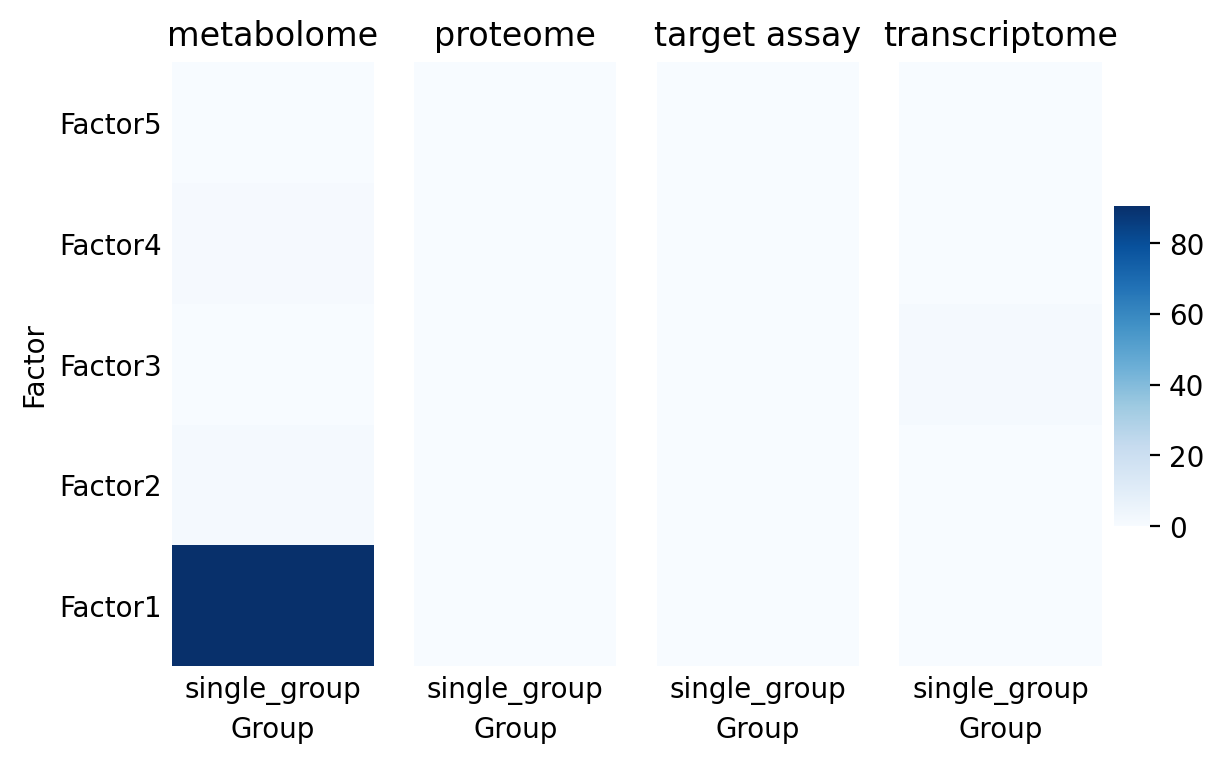

In [20]:
mfx.plot_r2(m)

<AxesSubplot:>

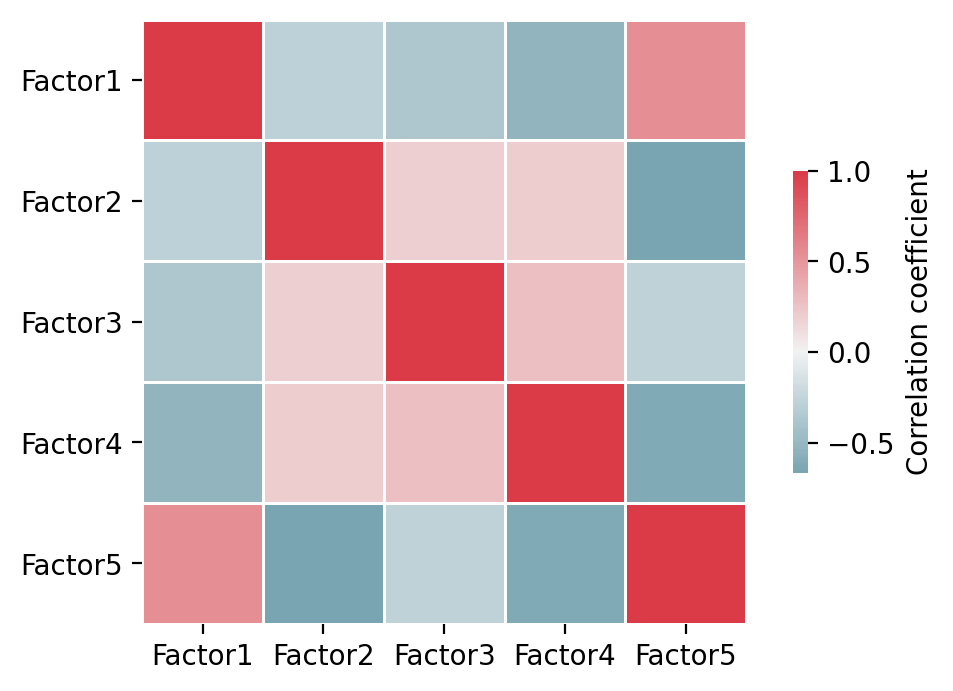

In [21]:

mfx.plot_factors_correlation(m)


<AxesSubplot:ylabel='Factor value'>

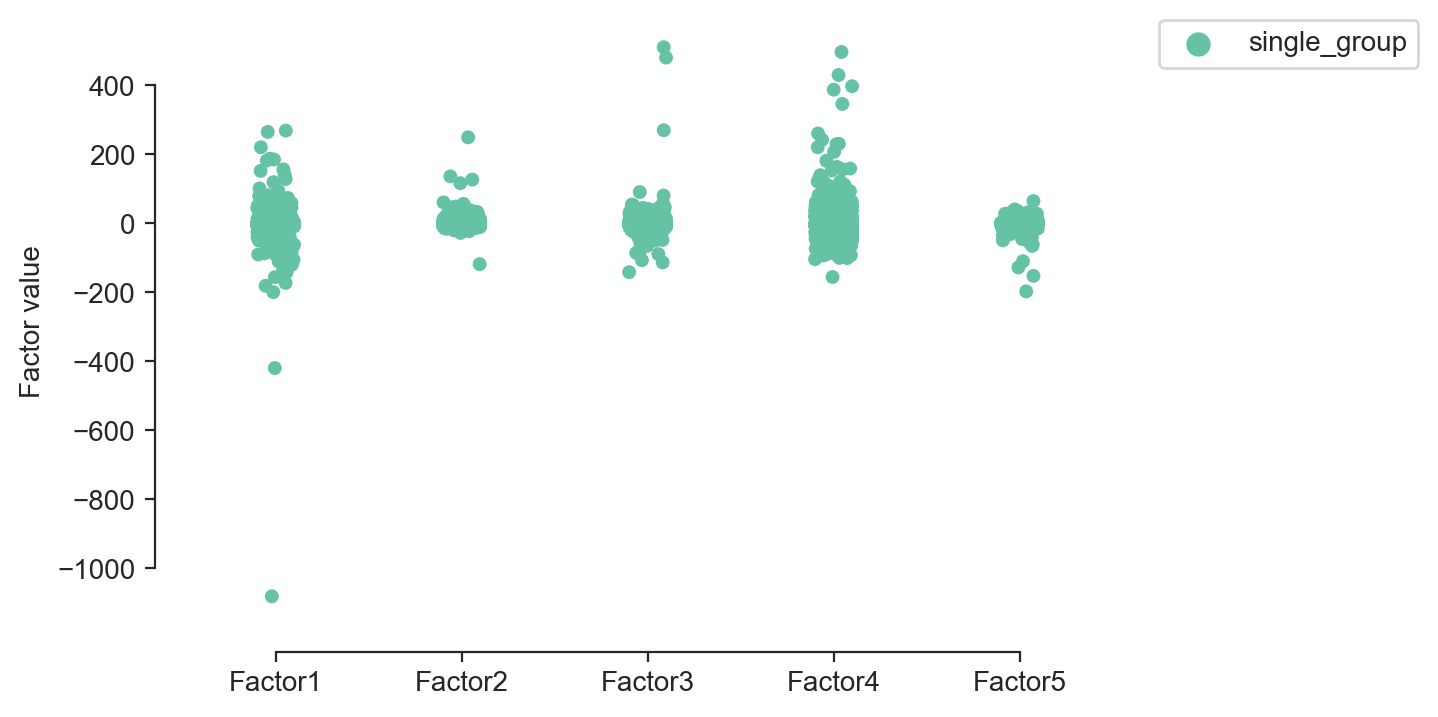

In [85]:
mfx.plot_factors(m)

<AxesSubplot:>

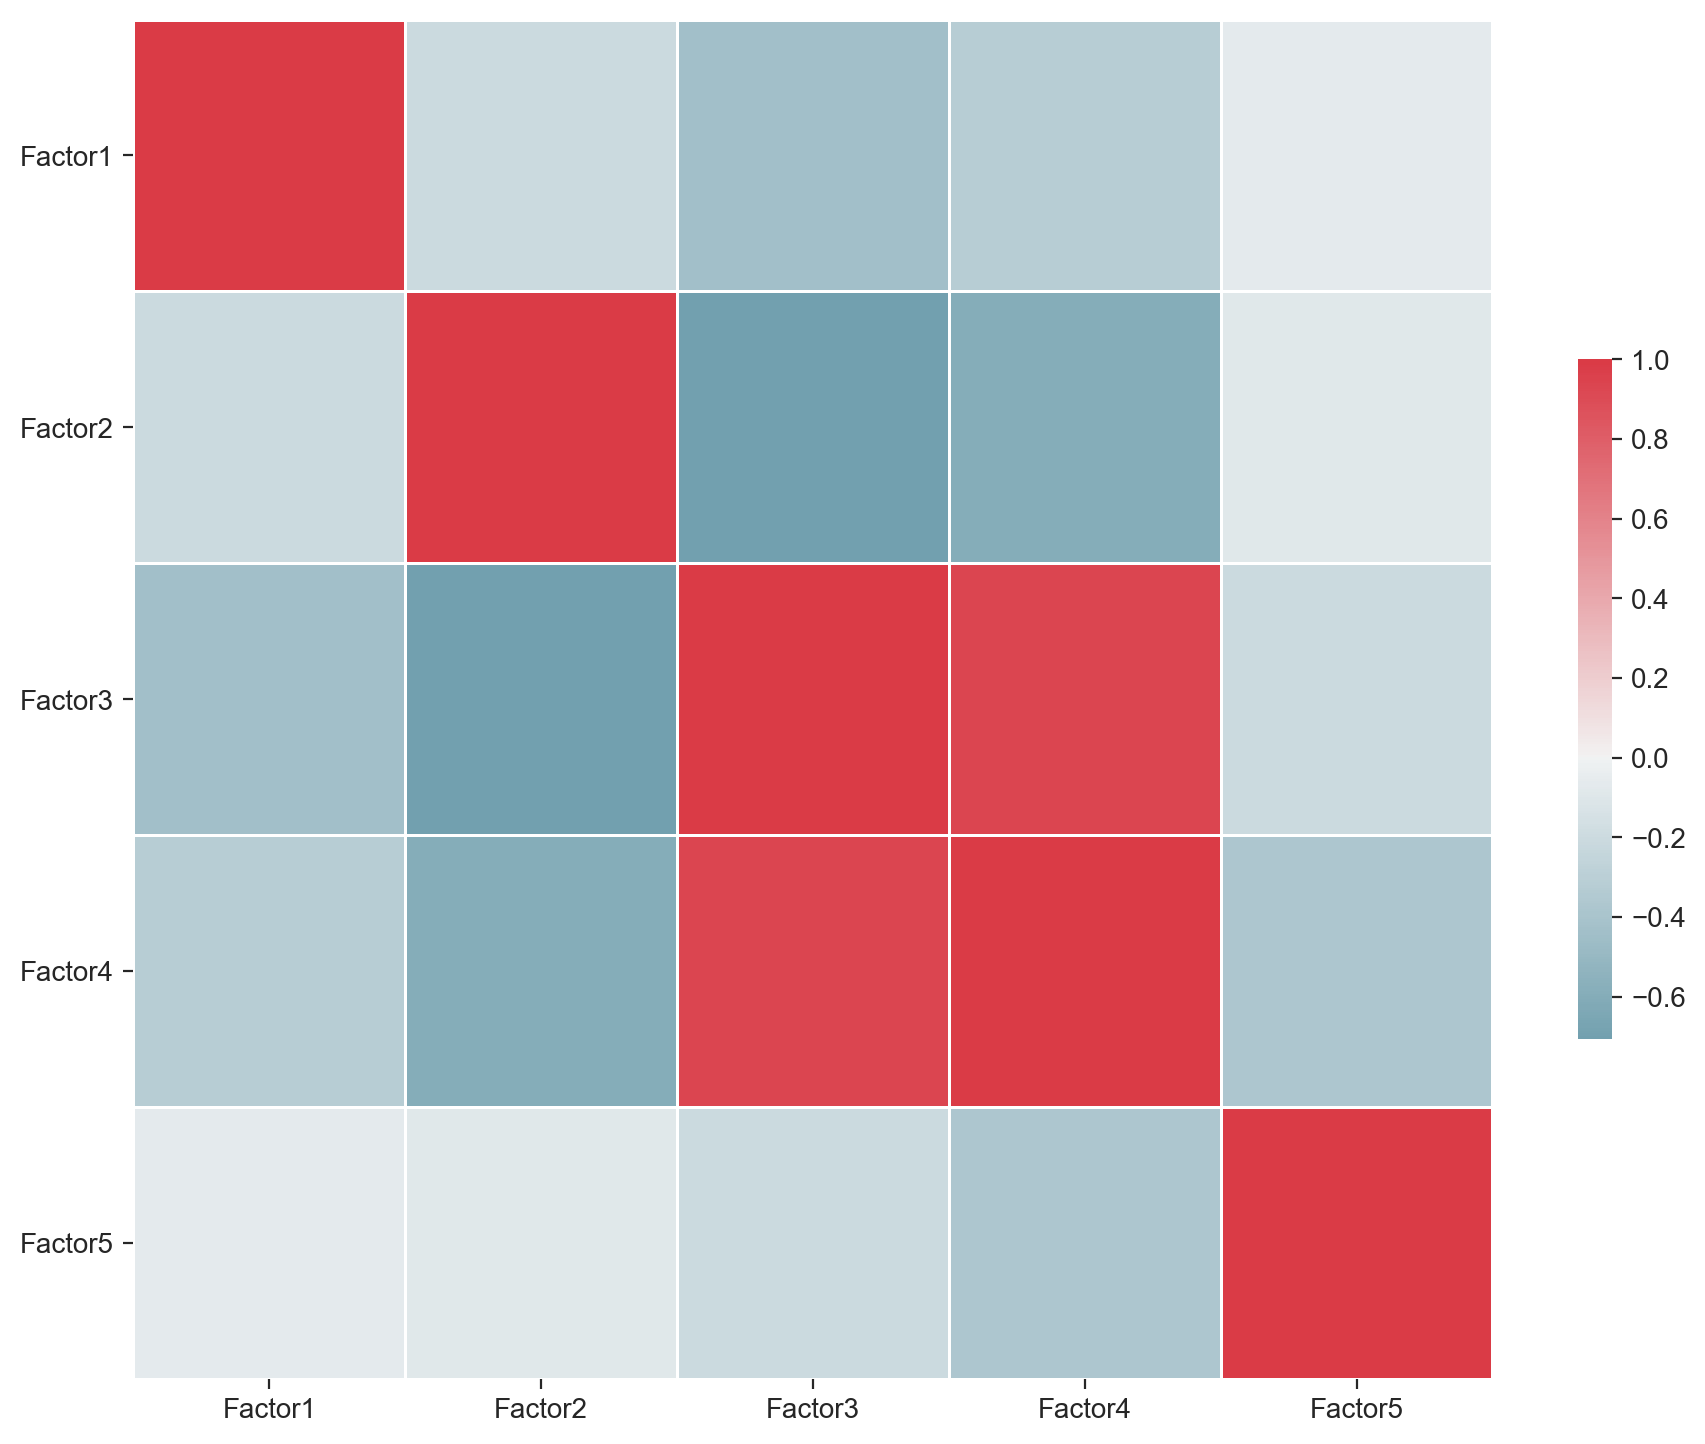

In [109]:
mfx.plot_weights_correlation(m)

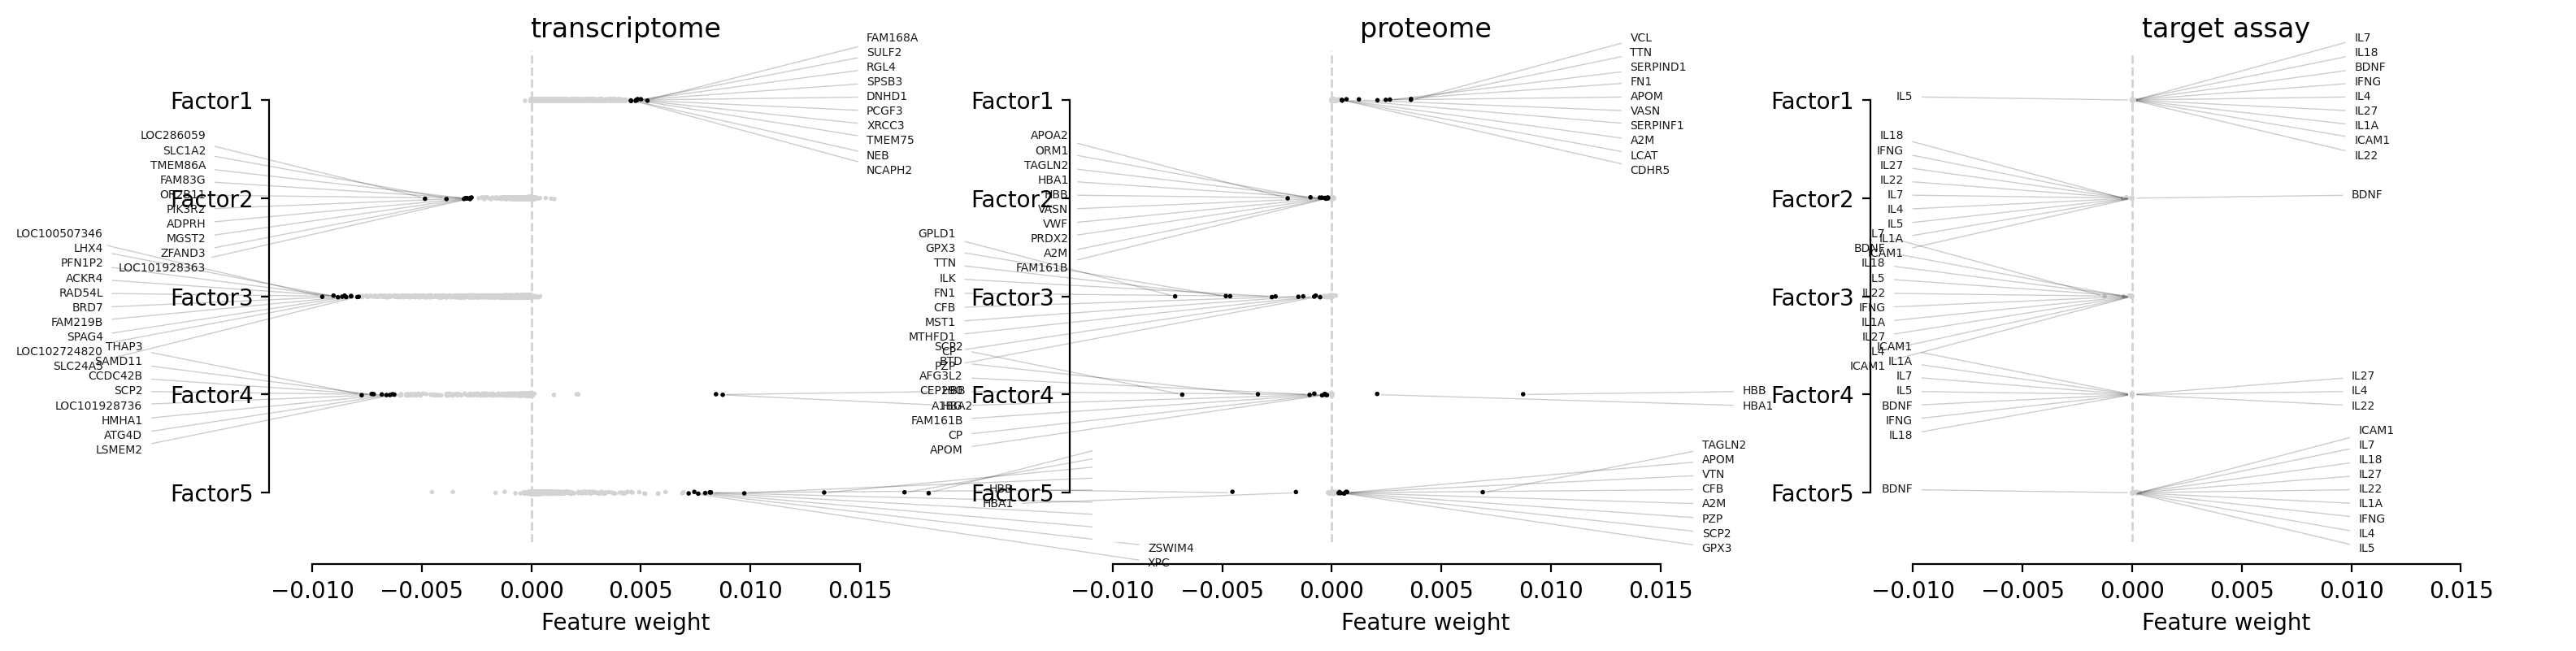

In [22]:
ax = mfx.plot_weights(m, factor=1, views = 'transcriptome', n_features=10,
                      y_repel_coef=0.04, x_rank_offset=-150)

# still plot miltiple views though the views parameter is set to be 'transcriptome'

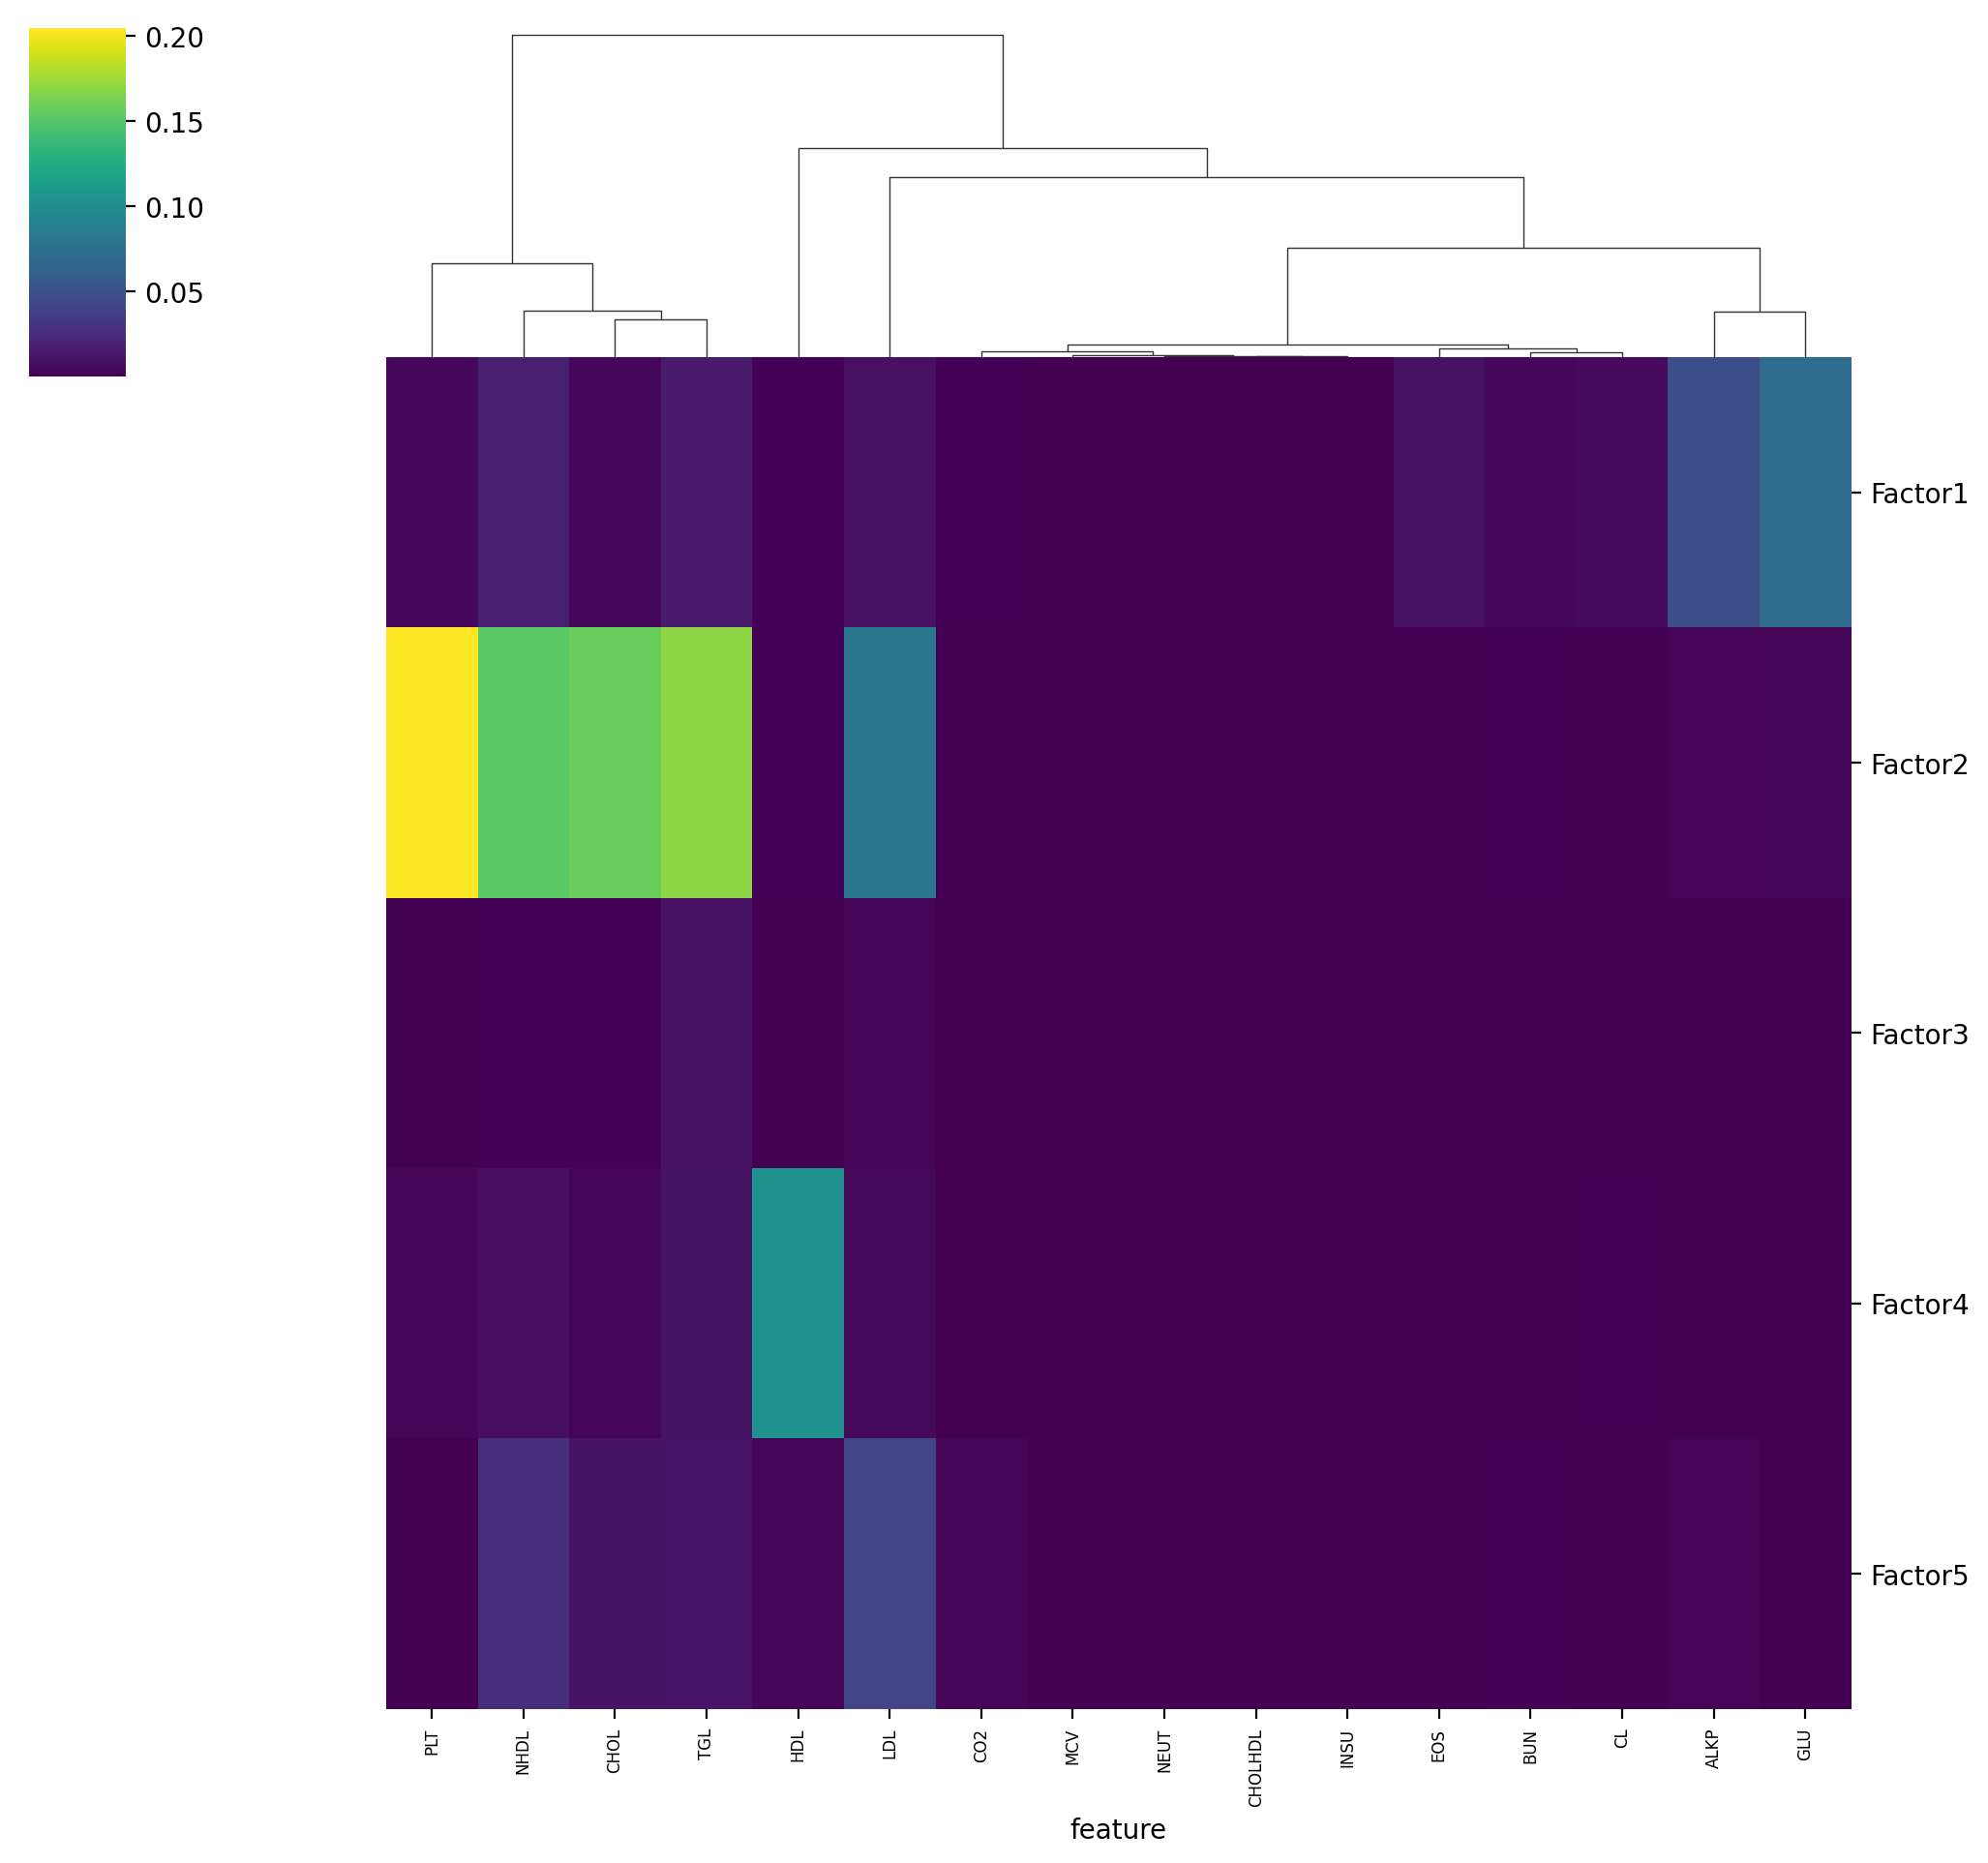

In [13]:

mfx.plot_weights_heatmap(m, n_features=10, 
                         factors=range(0, 5), 
                         xticklabels_size=6, w_abs=True, 
                         cmap="viridis", cluster_factors=False)


<AxesSubplot:xlabel='Feature rank', ylabel='Factor1 weight'>

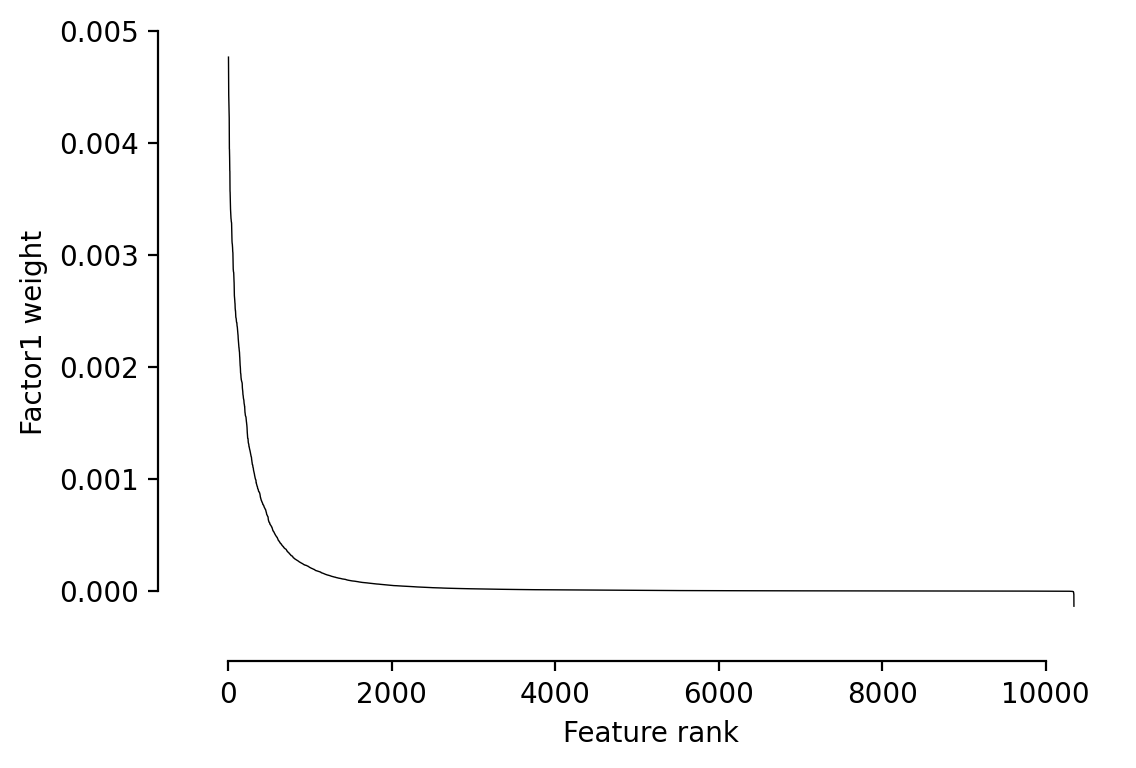

In [99]:
mfx.plot_weights_ranked(m, factor="Factor1",  view='transcriptome', n_features = 1)

In [150]:
# to get dataFrame for top features

df = m.get_top_features(views = 'transcriptome', factors = 1, n_features = 10,df = True)

# this function returns values from multiple views though the views paramerter is set to be 'transcriptome'

In [152]:
# Problem handle


'''
for l in range(len(df['view'].tolist())):
    if df['view'][l] != 'transcriptome':
        df = df.drop(labels = l)
df 
'''
   

,index,feature,factor,value,value_abs,view
0,5048,LOC286059,Factor2,-0.004729,0.004729,transcriptome
1,8244,SLC1A2,Factor2,-0.003943,0.003943,transcriptome
2,205,ADPRH,Factor2,-0.003035,0.003035,transcriptome
3,6766,PIK3R2,Factor2,-0.003011,0.003011,transcriptome
4,6379,OR2B11,Factor2,-0.003004,0.003004,transcriptome
5,9295,TMEM86A,Factor2,-0.002950,0.002950,transcriptome
6,2945,FAM83G,Factor2,-0.002868,0.002868,transcriptome
7,5533,MGST2,Factor2,-0.002857,0.002857,transcriptome
8,10181,ZFAND3,Factor2,-0.002819,0.002819,transcriptome
9,4945,LOC101928363,Factor2,-0.002772,0.002772,transcriptome


In [169]:
def plot_top_features(
    m,
    factors: Union[int] = None,
    views: Union[str, int] = None,
    n_features: int = None,
    clip_threshold: float = None,
    scale: bool = False,
    absolute_values: bool = False,
    only_positive: bool = False,
    only_negative: bool = False,
    per_view: bool = True
):

    df = m.get_top_features(
        factors = factors,
        views = views,
        n_features = n_features,
        clip_threshold = clip_threshold,
        scale = scale,
        absolute_values = absolute_values,
        only_positive = only_positive,
        only_negative = only_negative,
        per_view = per_view,
        df = True,
    )
    
    
    for l in range(len(df['view'].tolist())):
        if df['view'][l] != views:
            df = df.drop(labels = l)
    
    fig, ax = plt.subplots()
    
    ax.axes.set_xlabel('Weights')
    ax.axes.set_ylabel('Features')
    title = views + " factor " + str(factors)
    ax.axes.set_title(title)
    
    ax.axes.axvline(x=0,linewidth=0.5, color='grey',linestyle = '-.')
    
    data = df['value'].tolist()
    data.reverse()
    label = df['feature'].tolist()
    label.reverse()
    
    b = ax.barh(range(len(df['value'].tolist())), data, tick_label=label, color = 'black', height=0.05)
    ax.scatter(data, y=label, color='black', s=40)
    
    #plt.show()
    
    return(fig)

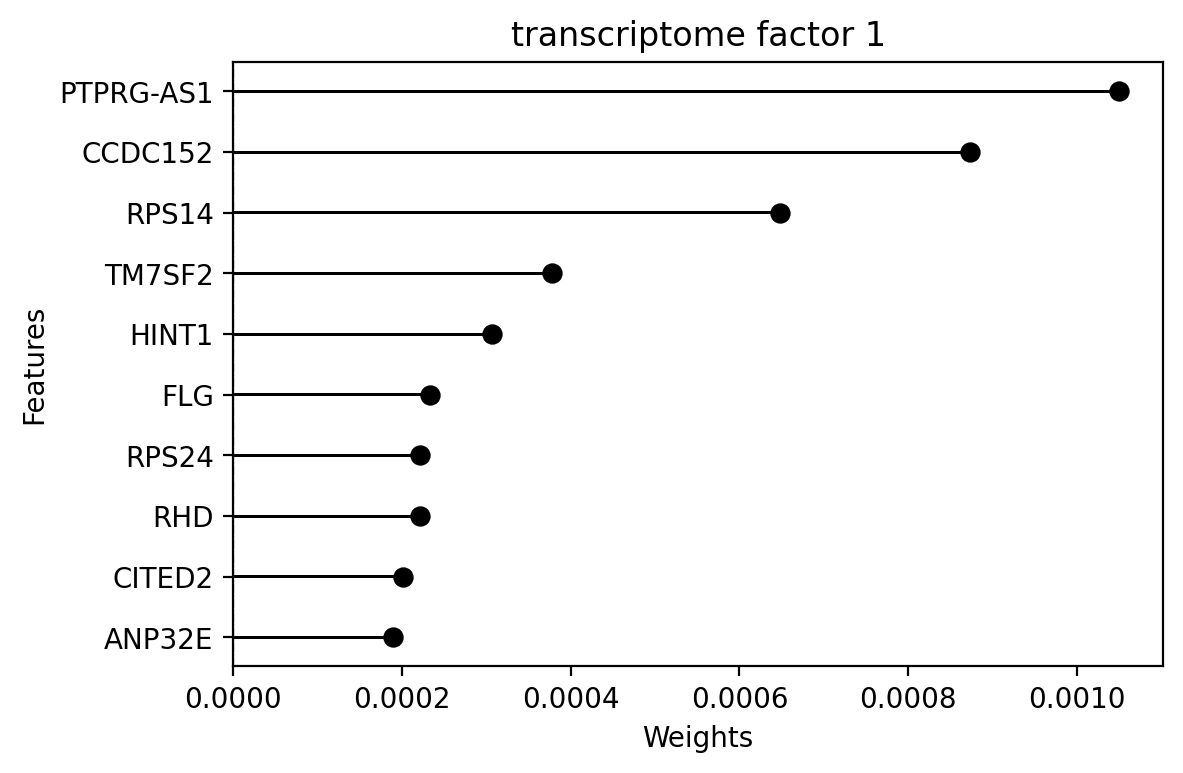

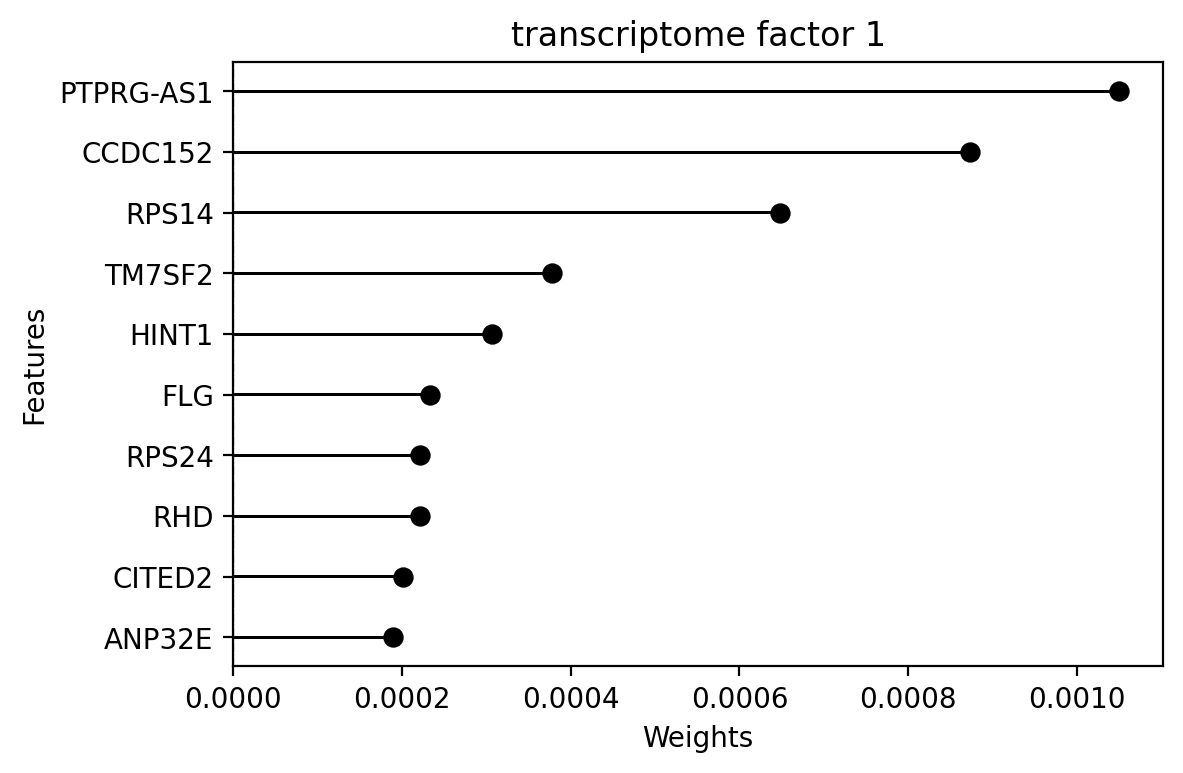

In [170]:
plot_top_features(m, factors = 1, views = 'transcriptome', only_positive = True, n_features = 10)

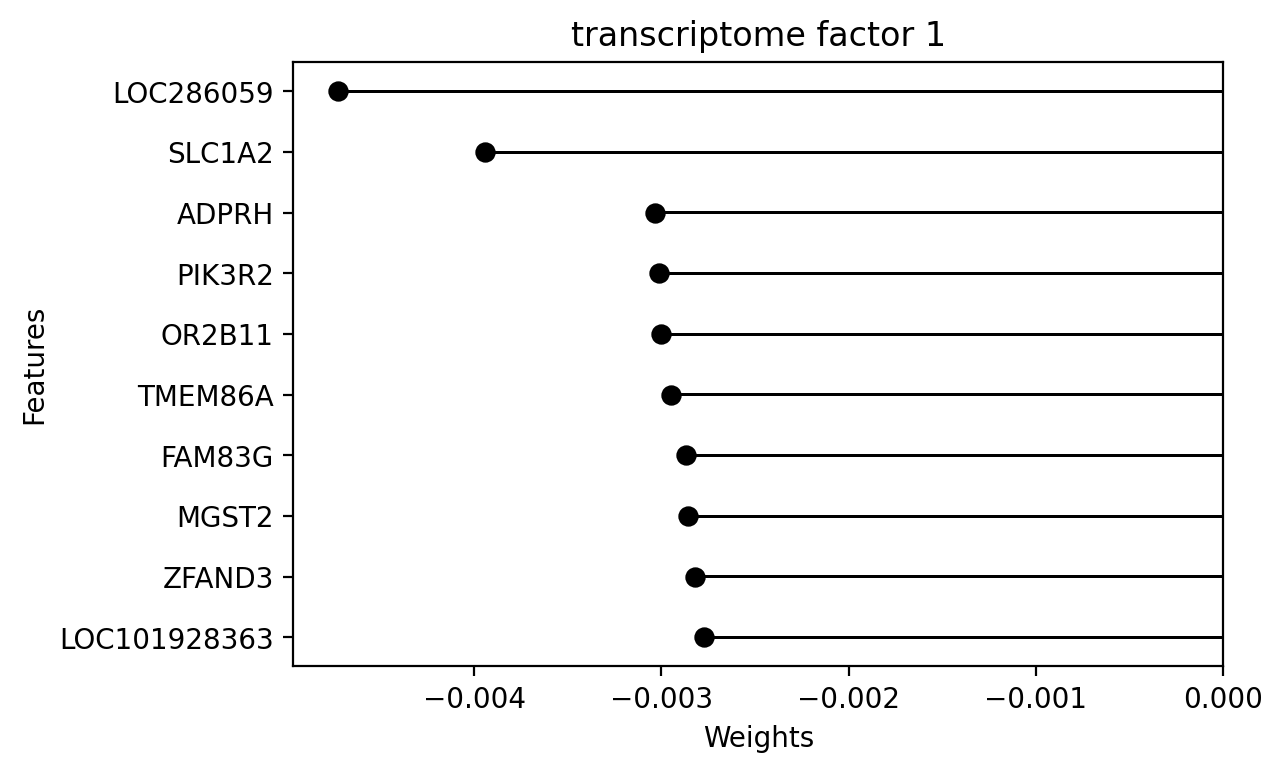

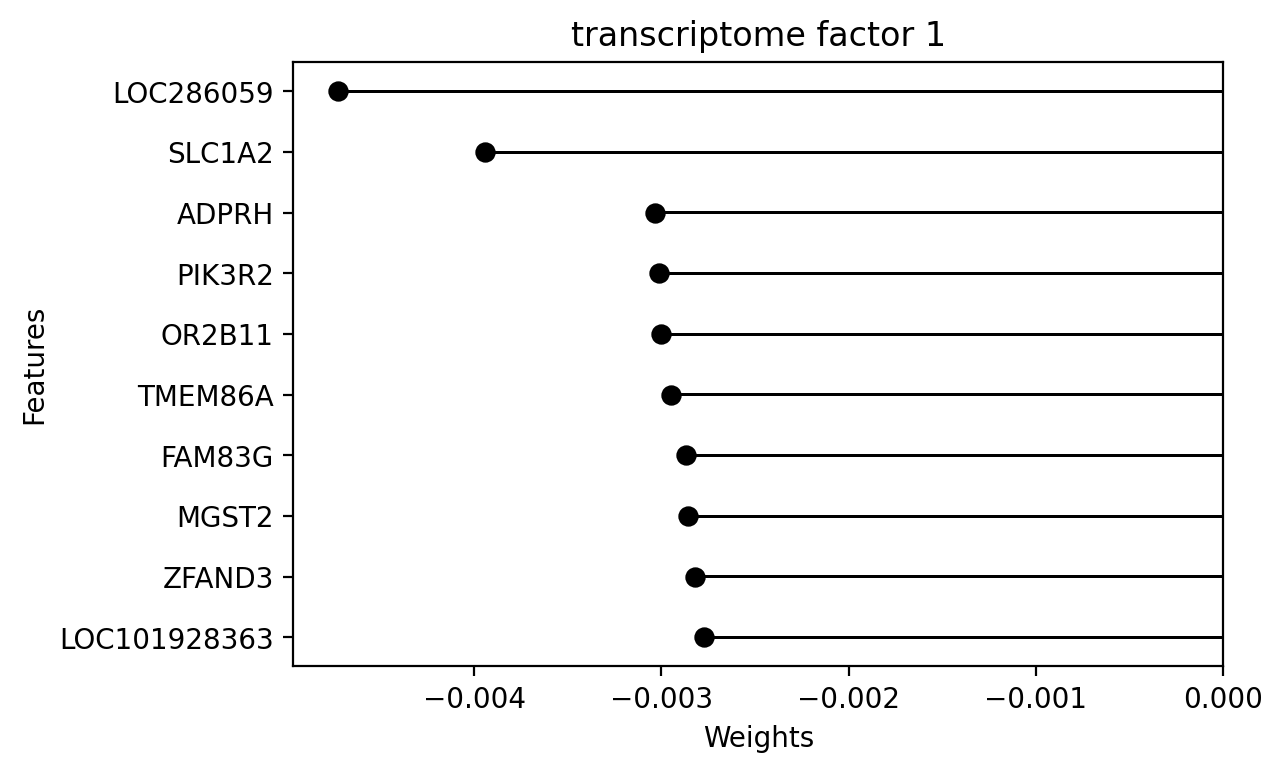

In [156]:
plot_top_features(m, factors = 1, views = 'transcriptome', only_negative = True, n_features = 10)

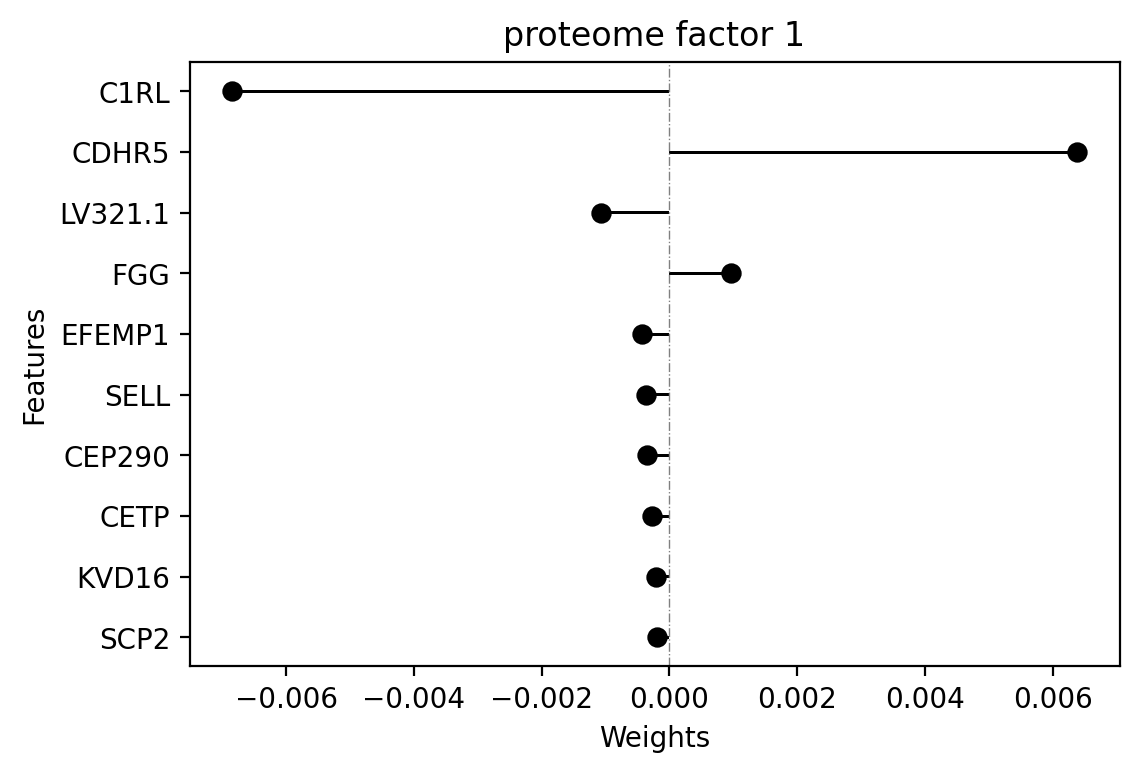

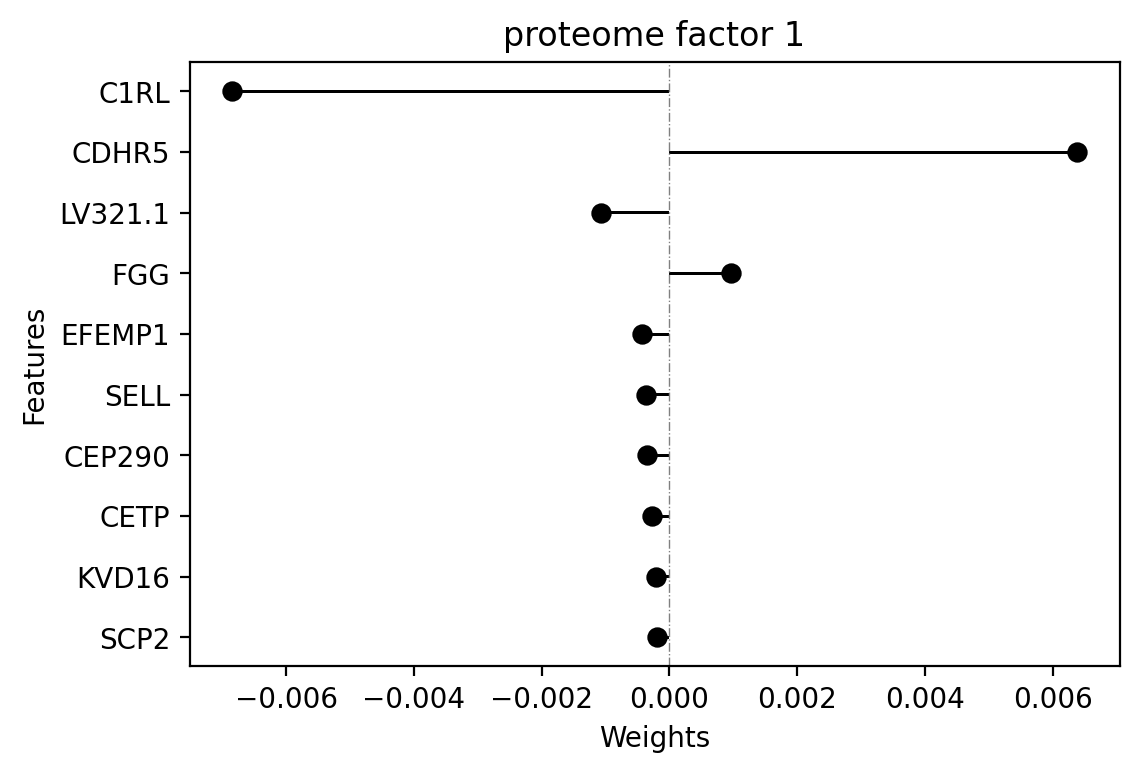

In [158]:
plot_top_features(m, factors = 1, views = 'proteome', n_features = 10)